# federated-ml-health 
**Notatnik przystosowany do zajęć z SI w informatyce biomedycznej**.

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
# To install TFF and dependencies
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade nest-asyncio






# Przygotowanie danych

Na początku wykorzystamy zbiór `pima`. W dalszej kolejności będziemy pracować na odpowiednio przygotowanej wersji zbioru MIMIC-III.

In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [6]:
import collections
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import tensorflow_federated as tff
from collections import defaultdict 
from matplotlib.pyplot import figure
from numpy import loadtxt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import scipy
from scipy.stats import beta
from sklearn.model_selection import KFold
import seaborn as sns

2022-06-02 19:35:53.166155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-02 19:35:53.166171: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
nest_asyncio.apply()
tff.framework.set_default_context(tff.backends.native.create_thread_debugging_execution_context(clients_per_thread=50))
np.random.seed(10)
tf.random.set_seed(10)


In [8]:
raw_ds = pd.read_csv('pima.csv')
num_col = raw_ds.shape[1]
X = raw_ds.iloc[:, 0:num_col-1].values
y = raw_ds.iloc[:, num_col-1].values

## Podział na część uczącą i testującą

Tym razem porządniej -- `scaler` oraz `imputer` są uczone na danych uczących i stosowane do danych testowych.

In [9]:
TRAIN_PROPORTION = 0.8
NUM_FEATURES = X.shape[1]
NUM_ROUNDS = 8
n_train = round(TRAIN_PROPORTION * np.size(X, 0))

X_train = X[:n_train]
y_train =  y[:n_train]
X_test = X[n_train:]
y_test =  y[n_train:]

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline 

preprocessor = make_pipeline(SimpleImputer(), StandardScaler())

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# D = np.column_stack((X, y))
# ds = pd.DataFrame(
#     data=D,
#     columns=raw_ds.columns)
# ds

# Podejście scentralizowane

## Regresja - scikit-learn


In [11]:
sk_model = LogisticRegression(random_state=0, solver='liblinear').fit(X_train, y_train)
proba_test = sk_model.predict_proba(X_test)[:,1]
fpr_skl_liblinear, tpr_skl_liblinear, threshold_skl_liblinear = sklearn.metrics.roc_curve(y_test, proba_test)
roc_auc_skl_liblinear = sklearn.metrics.auc(fpr_skl_liblinear, tpr_skl_liblinear)
print(f'AUC-LIN = {roc_auc_skl_liblinear:.4}')

AUC-LIN = 0.8481


In [12]:
sk_model = LogisticRegression(random_state=0, solver='sag', max_iter=500).fit(X_train, y_train)
proba_test = sk_model.predict_proba(X_test)[:,1]
fpr_skl_sag, tpr_skl_sag, threshold_skl_sag = sklearn.metrics.roc_curve(y_test, proba_test)
roc_auc_skl_sag = sklearn.metrics.auc(fpr_skl_sag, tpr_skl_sag)
print(f'AUC-SAG = {roc_auc_skl_sag:.4}')

AUC-SAG = 0.8479


In [13]:
sk_model = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)
proba_test = sk_model.predict_proba(X_test)[:,1]
fpr_skl, tpr_skl, threshold_skl = sklearn.metrics.roc_curve(y_test, proba_test)
roc_auc_skl = sklearn.metrics.auc(fpr_skl, tpr_skl)
print(f'AUC-SKL = {roc_auc_skl:.4}')

AUC-SKL = 0.8481


## Regresja - TF

Wyjaśnienie odnośnie definicji modelu (oryginalny projekt): *Adam optimization method is used to mimic the sklearn solver as close as possible (leveraging second derivatives of gradient).*

In [14]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(n_train)
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(n_train)

def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Dense(
          1,
          activation='sigmoid',
          input_shape=(NUM_FEATURES,),
          kernel_regularizer=tf.keras.regularizers.l2(0.01),
      )
  ])

def create_keras_model_deeper():
  initializer = tf.keras.initializers.GlorotNormal(seed=10)
  m = tf.keras.models.Sequential()
  m.add(tf.keras.Input(shape=(NUM_FEATURES,)))
  m.add(tf.keras.layers.Dense(6, activation='sigmoid', kernel_initializer=initializer))
  m.add(tf.keras.layers.Dense(3, activation='sigmoid', kernel_initializer=initializer))
  m.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0001, l2=0.01)))
  return m
  

tf_model = create_keras_model()
tf_model.compile(
              optimizer=tf.keras.optimizers.Nadam(learning_rate=0.5),   
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[
                       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.AUC(name='auc'),
                       ]
              )

batch_size = round(n_train/3)
tf_model.fit(dataset_train, validation_data=dataset_test, epochs=NUM_ROUNDS, batch_size=batch_size, verbose=1, use_multiprocessing=True)

proba_test = tf_model.predict(dataset_test)
fpr_tf, tpr_tf, threshold = sklearn.metrics.roc_curve(y_test, proba_test)
roc_auc_tf = sklearn.metrics.auc(fpr_tf, tpr_tf)
print(f'AUC-TF = {roc_auc_tf:0.4}')

Epoch 1/8


2022-06-02 19:35:55.967857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-02 19:35:55.967877: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-02 19:35:55.967894: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (st60382): /proc/driver/nvidia/version does not exist
2022-06-02 19:35:55.968727: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 1s 603ms/step - loss: 0.8263 - accuracy: 0.5537 - auc: 0.6096 - val_loss: 0.5713 - val_accuracy: 0.7468 - val_auc: 0.7900
Epoch 2/8
1/1 [==============================] - 0s 8ms/step - loss: 0.5933 - accuracy: 0.7362 - auc: 0.7462 - val_loss: 0.5528 - val_accuracy: 0.7338 - val_auc: 0.7908
Epoch 3/8
1/1 [==============================] - 0s 9ms/step - loss: 0.5178 - accuracy: 0.7752 - auc: 0.8221 - val_loss: 0.5033 - val_accuracy: 0.7662 - val_auc: 0.8507
Epoch 4/8
1/1 [==============================] - 0s 11ms/step - loss: 0.4921 - accuracy: 0.7752 - auc: 0.8334 - val_loss: 0.5092 - val_accuracy: 0.7532 - val_auc: 0.8412
Epoch 5/8
1/1 [==============================] - 0s 10ms/step - loss: 0.4881 - accuracy: 0.7834 - auc: 0.8370 - val_loss: 0.5050 - val_accuracy: 0.7597 - val_auc: 0.8512
Epoch 6/8
1/1 [==============================] - 0s 9ms/step - loss: 0.4877 - accuracy: 0.7834 - auc: 0.8370 - val_loss: 0.5091 - val_accuracy: 0.7532 - val_auc:

# Regresja - TF Federated

Utworzenie zbioru z danymi uczącymi, aby ułatwić przydział danych do poszczególnych klientów

In [15]:
df_data_train = pd.DataFrame(data=X_train, columns=raw_ds.columns[:-1])
df_labels_train = pd.DataFrame(data=y_train, columns=raw_ds.columns[-1:])

Przypisanie identyfikatorów (indeksów) przykładów uczących do poszczególnych klientów. Obecnie wszyscy klienci otrzymują taką samą liczbę przykładów, przy czym rozkład klas nie jest zachowywany.

In [32]:
def assign_samples_to_clients(data, n_clients:int, mode:str = None, beta_dist=None):
    client_sample_ids = []
    if mode == "a=5,b=2":
        print("a=5,b=2")
        a,b = 5,2
    elif mode == "a=2,b=5":
        print("a=2,b=5")
        a,b = 2,5
    elif mode == "a=2,b=2":
        print("a=2,b=2")
        a,b = 2,2
    else:
        kf = KFold(n_splits=n_clients, shuffle=True, random_state=42)
        for _, test_ids in kf.split(data):
            client_sample_ids.append(test_ids)
        return client_sample_ids, None
    num_sampless = len(data)
    if beta_dist is None:
        beta_dist = beta.rvs(a=a, b=b, size=20)
    number_of_samples_per_client = np.round(beta_dist / np.sum(beta_dist) * num_sampless)
    ramaining_indices = list(range(len(data)))
    for client in range(n_clients-1):
        selected_indicies = []
        taken_indices = np.random.choice(list(range(len(ramaining_indices))), int(number_of_samples_per_client[client]), replace=False)
        for index in sorted(taken_indices, reverse=True):
            selected_indicies.append(ramaining_indices.pop(index))
        client_sample_ids.append(np.array(selected_indicies))
    client_sample_ids.append(np.array(ramaining_indices))

    return (client_sample_ids, beta_dist)

def assign_samples_to_clients_tiered_allocation(data, y, n_clients:int, mode:str = None):
    """tiered allocation"""
    zero_indicies = np.where(y == 0)
    one_indicies = np.where(y == 1)

    one_data = data.loc[one_indicies]
    zero_data = data.loc[zero_indicies]

    zero_assigned_indicies, beta_dist = assign_samples_to_clients(zero_data, n_clients=n_clients, mode=mode)
    one_assigned_indicies, _ = assign_samples_to_clients(one_data, n_clients=n_clients, mode=mode, beta_dist=beta_dist)

    assigned_indicies = []
    for zero,one in zip(zero_assigned_indicies, one_assigned_indicies):
        assigned_indicies.append(np.array(list(zero)+list(one)))
    return assigned_indicies

In [34]:
def create_client_dataset(data, labels, client_ids, client_sample_ids):
  def create_dataset_fn(client_id):
    sample_ids = client_sample_ids[client_id]
    return tf.data.Dataset.from_tensor_slices((data.iloc[sample_ids, :].values, labels.iloc[sample_ids, :].values))

  return tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
      client_ids=client_ids,
      serializable_dataset_fn=create_dataset_fn)
  
def preprocess(dataset):
    card = dataset.cardinality()
    batch_size = 1 if card ==  tf.data.INFINITE_CARDINALITY or tf.data.UNKNOWN_CARDINALITY else round(card.numpy()/3)
    return dataset.batch(batch_size)

def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(id))
      for id in client_ids
  ]

def model_fn():
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
               tf.keras.metrics.AUC(name='auc')])

In [35]:
NUM_CLIENTS = 20
NUM_PARTICIPATING_PER_ROUND = round(NUM_CLIENTS/3)
client_ids = list(range(NUM_CLIENTS))

In [36]:
tiered_allocation = True
base_fpr = np.linspace(0, 1, 1001)
modes = ['uniform', 'a=2,b=2', 'a=5,b=2', 'a=2,b=5']
results = {}
for mode in modes:
  fpr_tff_sgd_all = []
  tpr_tff_sgd_all = []
  roc_auc_tff_sgd_all = []
  for _ in range(15):
    if tiered_allocation:
      client_sample_ids, _ = assign_samples_to_clients_tiered_allocation(df_data_train, y=y_train, n_clients=20, mode=mode)
    else:
      client_sample_ids, _ = assign_samples_to_clients(df_data_train, n_clients=20, mode=mode)

    client_dataset_train = create_client_dataset(df_data_train, df_labels_train, client_ids, client_sample_ids)

    preprocessed_example_dataset = preprocess(client_dataset_train.create_tf_dataset_for_client(client_ids[0]))

    # Create TFF interative process.
    iterative_process = tff.learning.build_federated_averaging_process(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
        server_optimizer_fn=lambda: tf.keras.optimizers.Nadam(learning_rate=0.5),
        use_experimental_simulation_loop = True
    )

    state = iterative_process.initialize()
    tff_model = create_keras_model()
    tff_auc = defaultdict(lambda:0)

    # Test various sizes of subsets of eligible devices participating in each round.
    for n_clients in list(range(1, NUM_CLIENTS, 5)):
      for i_round in range(NUM_ROUNDS):
        federated_train_data = make_federated_data(client_dataset_train, np.random.choice(range(NUM_CLIENTS), size=n_clients, replace=False))
        state, metrics = iterative_process.next(state, federated_train_data)
        print(n_clients, i_round, str(metrics))
        state.model.assign_weights_to(tff_model)
        proba_test = tff_model.predict(dataset_test)
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, proba_test)
        test_auc = sklearn.metrics.auc(fpr, tpr)
        test_loss = tf.keras.losses.binary_crossentropy(y_test, np.reshape(proba_test, [-1]))
        print(f'AUC = {test_auc:0.4}, Loss={test_loss:0.4}')

    state.model.assign_weights_to(tff_model)
    proba_test = tff_model.predict(dataset_test)
    fpr_tff_sgd, tpr_tff_sgd, threshold_tff_sgd = sklearn.metrics.roc_curve(y_test, proba_test)
    roc_auc_tff_sgd = sklearn.metrics.auc(fpr_tff_sgd, tpr_tff_sgd)

    print(f'mode: {mode} AUC-TFF = {roc_auc_tff_sgd:0.4}')
    tpr = np.interp(base_fpr, fpr_tff_sgd, tpr_tff_sgd)
    tpr[0] = 0.0
    tpr_tff_sgd_all.append(tpr)
    roc_auc_tff_sgd_all.append(roc_auc_tff_sgd)
  results[mode] = {'fpr_tff_sgd' : base_fpr, 
                  'tpr_tff_sgd' : np.mean(tpr_tff_sgd_all, axis=0), 
                  'roc_auc_tff_sgd' : np.mean(roc_auc_tff_sgd_all), 
                  'label' : f'{mode} TF Federated LR SGDM AUC = {np.round(np.mean(roc_auc_tff_sgd_all) , 3)}',
                  'std_tpr': np.std( tpr_tff_sgd_all, axis=0)}

1 0 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.7096774), ('auc', 0.6340909), ('loss', 1.3363487), ('num_examples', 31), ('num_batches', 31)]))])
AUC = 0.7673, Loss=0.6341
1 1 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.58064514), ('auc', 0.50333333), ('loss', 1.1424828), ('num_examples', 31), ('num_batches', 31)]))])
AUC = 0.7511, Loss=0.6217
1 2 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.58064514), ('auc', 0.54545456), ('loss', 1.7786155), ('num_examples', 31), ('num_batches', 31)]))])
AUC = 0.7671, Loss=0.6027
1 3 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.61290324), ('auc', 0.4758772), ('los

2022-06-02 19:39:15.400722: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


11 7 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.65), ('auc', 0.6417411), ('loss', 1.2009655), ('num_examples', 340), ('num_batches', 340)]))])
AUC = 0.8154, Loss=0.5883
16 0 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.67617106), ('auc', 0.66601616), ('loss', 1.093031), ('num_examples', 491), ('num_batches', 491)]))])
AUC = 0.8184, Loss=0.5848
16 1 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.67959183), ('auc', 0.66561586), ('loss', 1.1125014), ('num_examples', 490), ('num_batches', 490)]))])
AUC = 0.8171, Loss=0.5748
16 2 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6707317), ('auc', 0.6390543), ('

2022-06-02 19:41:37.281248: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


1 2 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6363636), ('auc', 0.6365385), ('loss', 1.3491364), ('num_examples', 33), ('num_batches', 33)]))])
AUC = 0.7511, Loss=0.6042
1 3 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6363636), ('auc', 0.5619048), ('loss', 0.85775656), ('num_examples', 22), ('num_batches', 22)]))])
AUC = 0.7781, Loss=0.626
1 4 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.68421054), ('auc', 0.71428573), ('loss', 0.89909375), ('num_examples', 19), ('num_batches', 19)]))])
AUC = 0.7941, Loss=0.6033
1 5 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.60714287), ('auc', 0.4387755), ('loss

2022-06-02 19:41:52.600437: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


11 1 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6785714), ('auc', 0.71610236), ('loss', 0.93989706), ('num_examples', 336), ('num_batches', 336)]))])
AUC = 0.7603, Loss=0.679
11 2 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6869565), ('auc', 0.6915855), ('loss', 1.0595851), ('num_examples', 345), ('num_batches', 345)]))])
AUC = 0.7927, Loss=0.6201
11 3 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.7080745), ('auc', 0.73078716), ('loss', 0.93500483), ('num_examples', 322), ('num_batches', 322)]))])
AUC = 0.7851, Loss=0.6233
11 4 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6796116), ('auc', 0.6983920

2022-06-02 19:42:04.349987: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


11 2 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6547231), ('auc', 0.68604064), ('loss', 1.2244374), ('num_examples', 307), ('num_batches', 307)]))])
AUC = 0.7559, Loss=0.8207
11 3 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.69018406), ('auc', 0.70495844), ('loss', 1.1065718), ('num_examples', 326), ('num_batches', 326)]))])
AUC = 0.7726, Loss=0.7406
11 4 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6834734), ('auc', 0.7022878), ('loss', 1.1033767), ('num_examples', 357), ('num_batches', 357)]))])
AUC = 0.7754, Loss=0.7099
11 5 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.7311828), ('auc', 0.7255580

2022-06-02 19:46:15.428728: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


6 0 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.71428573), ('auc', 0.75593424), ('loss', 0.92564553), ('num_examples', 189), ('num_batches', 189)]))])
AUC = 0.8121, Loss=0.6129
6 1 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6966292), ('auc', 0.64755565), ('loss', 0.95584756), ('num_examples', 178), ('num_batches', 178)]))])
AUC = 0.8147, Loss=0.5999
6 2 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.71257484), ('auc', 0.7323828), ('loss', 0.91093254), ('num_examples', 167), ('num_batches', 167)]))])
AUC = 0.8197, Loss=0.5846
6 3 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6927711), ('auc', 0.7229406

2022-06-02 19:46:21.190334: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


16 0 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6729958), ('auc', 0.71134096), ('loss', 0.99132), ('num_examples', 474), ('num_batches', 474)]))])
AUC = 0.8129, Loss=0.6159
16 1 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6802326), ('auc', 0.70578384), ('loss', 0.9972359), ('num_examples', 516), ('num_batches', 516)]))])
AUC = 0.8114, Loss=0.6171
16 2 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6946721), ('auc', 0.72731614), ('loss', 0.9075167), ('num_examples', 488), ('num_batches', 488)]))])
AUC = 0.8173, Loss=0.5884
16 3 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.68921775), ('auc', 0.6966354)

2022-06-02 19:47:38.403440: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


11 4 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.68700266), ('auc', 0.7146089), ('loss', 1.0195899), ('num_examples', 377), ('num_batches', 377)]))])
AUC = 0.8083, Loss=0.6222
11 5 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.71267605), ('auc', 0.6963993), ('loss', 0.9800674), ('num_examples', 355), ('num_batches', 355)]))])
AUC = 0.8235, Loss=0.5811
11 6 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.6837607), ('auc', 0.6994902), ('loss', 1.0417835), ('num_examples', 351), ('num_batches', 351)]))])
AUC = 0.8171, Loss=0.5829
11 7 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.7044199), ('auc', 0.70552653

2022-06-02 19:48:01.042565: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


11 0 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.7275281), ('auc', 0.727853), ('loss', 0.91228235), ('num_examples', 356), ('num_batches', 356)]))])
AUC = 0.8595, Loss=0.5065
11 1 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.7448071), ('auc', 0.76852965), ('loss', 0.73638606), ('num_examples', 337), ('num_batches', 337)]))])
AUC = 0.858, Loss=0.5095
11 2 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.75), ('auc', 0.7681993), ('loss', 0.76151204), ('num_examples', 312), ('num_batches', 312)]))])
AUC = 0.8575, Loss=0.5124
11 3 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.7081851), ('auc', 0.67936563), ('

### Porównanie stworzonych modeli

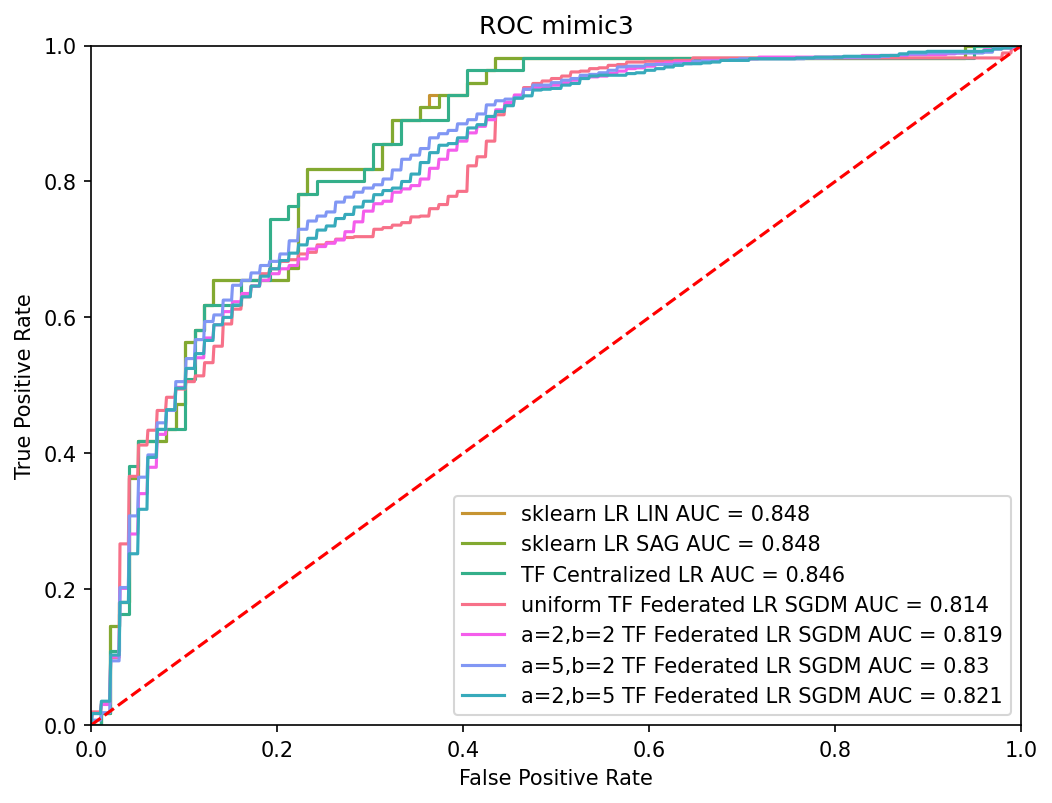

In [38]:
colors = sns.color_palette("husl", 7)
figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
plt.title('ROC mimic3')
plt.plot(fpr_skl_liblinear, tpr_skl_liblinear, label = 'sklearn LR LIN AUC = %0.3f' % roc_auc_skl_liblinear, c=colors[1])
plt.plot(fpr_skl_sag, tpr_skl_sag, label = 'sklearn LR SAG AUC = %0.3f' % roc_auc_skl_sag, c=colors[2])
plt.plot(fpr_tf, tpr_tf, label = 'TF Centralized LR AUC = %0.3f' % roc_auc_tf, c=colors[3])
for i,mode in enumerate(modes):
    plt.plot(results[mode]['fpr_tff_sgd'], results[mode]['tpr_tff_sgd'], label = results[mode]['label'], c=colors[-i])
    sdt = results[mode]['std_tpr']
    # plt.fill_between(results[mode]['fpr_tff_sgd'], results[mode]['tpr_tff_sgd']-sdt, results[mode]['tpr_tff_sgd']+sdt ,alpha=0.3, facecolor=colors[-i])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [81]:
sdt 

0.22112497661266775

In [59]:
for x in fpr_tff_sgd_all:
    print(x.shape)

(1223,)
(1327,)
(1247,)
(1298,)
(1237,)


In [66]:
results[mode]['tpr_tff_sgd']

0.6882520828959475

In [60]:
dataset_test

<BatchDataset element_spec=(TensorSpec(shape=(None, 26), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [67]:
tpr

array([0.        , 0.01833568, 0.03385049, ..., 0.99858956, 0.99858956,
       1.        ])

In [70]:
np.mean(tpr_tff_sgd_all, axis=0)

array([0.        , 0.01692525, 0.03244006, ..., 0.99858956, 0.99858956,
       1.        ])